<h1 style="font-size:35px;
        color:black;
        ">Lab 3 Quantum Phase Estimation</h1>

Prerequisite
- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

Other relevant materials
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [7]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt
import math

<h2 style="font-size:24px;">Part 1: Performance of Quantum Phase Estimation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.</p>
</div>


The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. In this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

<h3 style="font-size: 20px">1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.</h3> 

<h4 style="font-size: 17px">&#128211;Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'.  Execute 'qc4' on a Aer simulator.  Plot the histogram of the result.</h4>

Check the QPE chapter in Qiskit textbook ( go to `3. Example: Getting More Precision` section [here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html#3.-Example:-Getting-More-Precision-) ) for the circuit.

In [1]:
#Quantum Fouriter transform
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [16]:
#Decalre Circuit Object
qc4 = QuantumCircuit(5, 4)
#initialize the wavefunction
qc4.x(4)
#Hadamart all counting qbits
qc4.h(0)
qc4.h(1)
qc4.h(2)
qc4.h(3)

#Add U gates to wave function bit (phase 1/3)
repetitions = 1
for counting_qubit in range(4):
    for i in range(repetitions):
        qc4.cp((2*math.pi)/3, counting_qubit, 4); # This is CU
    repetitions *= 2

#Add Inverse Fourier Transform
qc4.barrier()
qft_dagger(qc4, 4)

#Add Meassure Gates
qc4.barrier()
for n in range(4):
    qc4.measure(n,n)

#Draw Circuit
qc4.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_4: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 4/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_4: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 4/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                          ░    ┌───┐                                   »
«q_0: ─────────────────────░──X─┤ H ├─■──────────────■──────────────────»
«                          ░  │ └───┘ │P(-π/2) ┌───┐ │                  »
«q_1: ─────────────────────░──┼───X───■────────┤ H ├─┼─────────■────────»
«                          ░  │   │            └───┘ │P(-π/4)  │P(-π/2) »
«q_2: ─────────────────────░──┼───X──────────────────■─────────■────────»
«                          ░  │                                         »
«q_3: ─■─────────■─────────░──X─────────────────────────────────────────»
«      │P(2π/3)  │P(2π/3)  ░                                            »
«q_4: ─■─────────■─────────░────────────────────────────────────────────»
«                          ░                                            »
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                              ░ ┌─┐         
«q_0: ─■───────────────────────────────────────░─┤M├─────────
«      │                                       ░ └╥┘┌─┐      
«q_1: ─┼──────────────■────────────────────────░──╫─┤M├──────
«      │        ┌───┐ │                        ░  ║ └╥┘┌─┐   
«q_2: ─┼────────┤ H ├─┼─────────■──────────────░──╫──╫─┤M├───
«      │P(-π/8) └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║ └╥┘┌─┐
«q_3: ─■──────────────■─────────■────────┤ H ├─░──╫──╫──╫─┤M├
«                                        └───┘ ░  ║  ║  ║ └╥┘
«q_4: ─────────────────────────────────────────░──╫──╫──╫──╫─
«                                              ░  ║  ║  ║  ║ 
«c: 4/════════════════════════════════════════════╩══╩══╩══╩═
«                                                 0  1  2  3

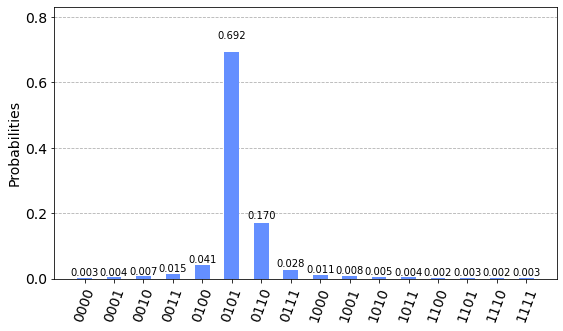

In [18]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

Having performed `Step A` successfully, you will have obtained a distribution similar to the one shown below with the highest probability at `0101` which corresponds to the estimated $\phi$ value, `0.3125`.

![](image/L3_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to $\delta = 2^{-4} = 0.0625$.  However, there are multiple possible outcomes as $\theta = 1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy. 

Running the following cell shows the same histogram but with all possible estimated $\phi$ values on the x-axis.

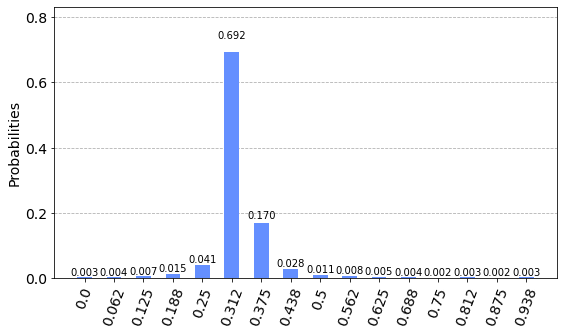

In [20]:
t = 4
phi_est = np.array([round(int(key, 2)/2**t,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**Suppose the outcome of the final measurement is $m$, and let $b$ the best estimation which is `0.3125` for this case.**
<h4 style="font-size: 17px">&#128211;Step B. Find $e$, the maximum difference in integer from the best estimation <code>0101</code> so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m - b| \leq \frac{e}{2^{t}}$. </h4>

In this case, the values of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e = 1$, the considered outcomes are `0100`, `0101`, `0110` which correspond to the values of $m$: $0.25,~0.312,~0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [50]:
#generate the values of phi
phi = np.array([int(key, 2)/2**t for key in list(count_qc4.keys())])

#sort the phi values so this method can work
phi.sort()

#number of qbits in system
t = 4

#start with e = 1 and increment as needed (increments at start of while loop to 1)
e = 0

#index in phi_est that corresponds to the highest probability in the plot
x = 5

#highest value in plot
b = phi[x]

#flag for loop break testing
running = True

while(running):
    e += 1
    for i in range(x - e, x + (e + 1)):
        #left side of inequality
        y = abs(phi[i] - b)
        #right side of inequality
        z = e / (2**t)
    
        #Test to see if the inequality is satisfied
        if (y > z):
            running = False
            break
        #Test to see if the error is satisfied
        if (abs(phi[i] - (1/3)) > (1/4)):
            running = False
            break
    
#Print out maximal working value of e.  e - 1 is this because the current value did not work.
print(e - 1)

3


<h4 style="font-size: 17px">&#128211;Step C. Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$.  Verify that the computed probability value is larger or equal to $1- \frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy. </h4>

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy $2^{-2}$ can be found based on the maximum difference $e$ from the best estimate. 

In [3]:
## Your code goes here














![](image/L3_e_max.png)

![](image/L3_prob_t.png)

The following graph exhibits the relationships with different accuracy levels.  The relationship, $t=n+log(2+\frac{1}{2\epsilon})$, indicates the number of counting qubits $t$ to estimate $\phi$ to an accuracy $2^{-2}$ with probability of success at least $1-\epsilon$, as we validated above. 

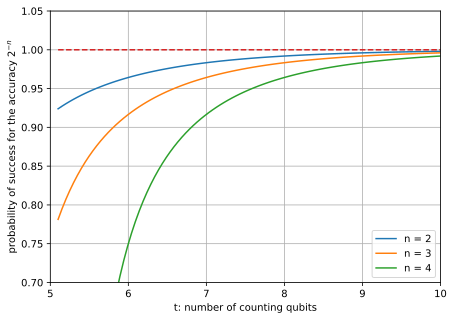

In [4]:
t = np.linspace(5.1, 10, 100)
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

![](image/L3_QPEresults.png)

![](image/L3_QPEresults_final.png)

![](image/L3_QPE_final.png)